# Predictive Delay Analytics

In [1]:
%matplotlib inline
# import required modules for prediction tasks
import numpy as np
import pandas as pd
import math
import random

## 1. Data acquisition

First, let's acquire the data formated in '02_data_preparation.ipynb'. The figure below gives a glimpse of what the data set looks like.

In [2]:
%%time
# reads all predefined months for a year and merge into one data frame
rawData2014 = pd.DataFrame.from_csv('cache/predictionData/complete2014Data.csv')

Wall time: 1min 49s


In [4]:
print rawData2014.columns
rawData2014.head(5)

Index([u'index', u'FL_DATE', u'UNIQUE_CARRIER', u'TAIL_NUM', u'FL_NUM',
       u'ORIGIN', u'DEST', u'CRS_DEP_TIME', u'DEP_TIME', u'DEP_DELAY',
       u'TAXI_OUT', u'WHEELS_OFF', u'WHEELS_ON', u'TAXI_IN', u'CRS_ARR_TIME',
       u'ARR_TIME', u'ARR_DELAY', u'CANCELLED', u'CANCELLATION_CODE',
       u'AIR_TIME', u'DISTANCE', u'CARRIER_DELAY', u'WEATHER_DELAY',
       u'NAS_DELAY', u'SECURITY_DELAY', u'LATE_AIRCRAFT_DELAY',
       u'AIRCRAFT_YEAR', u'AIRCRAFT_MFR', u'LAT', u'LONG'],
      dtype='object')


,index,FL_DATE,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,AIRCRAFT_YEAR,AIRCRAFT_MFR,LAT,LONG
0,0,2014-01-01,AA,N338AA,1,JFK,LAX,900,914,14,...,2475,NaN,NaN,NaN,NaN,NaN,1987,BOEING,40.633333,-73.783333
1,1,2014-01-02,AA,N338AA,1,JFK,LAX,900,857,-3,...,2475,NaN,NaN,NaN,NaN,NaN,1987,BOEING,40.633333,-73.783333
2,2,2014-01-03,AA,N323AA,1,JFK,LAX,900,NaN,NaN,...,2475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.633333,-73.783333
3,3,2014-01-04,AA,N327AA,1,JFK,LAX,900,1005,65,...,2475,0,59,0,0,0,1986,BOEING,40.633333,-73.783333
4,4,2014-01-05,AA,N323AA,1,JFK,LAX,900,1050,110,...,2475,0,110,0,0,0,NaN,NaN,40.633333,-73.783333


### Cleaning the data

We will focus on flights between New York and Chicago. When cleaning the data set, we have to remove the following entries:

- flights that have been cancelled or diverted. We focus on predicting the delay. As a result, we also remove the columns associated with diverted flights.
- colmuns that give the answer. This is the case of many colmuns related to the arrival of the plane
- rows where a value is missing
- flights whose destination or origin do not correspond to our study aim

Note that data points have to be cleaned in this order because most flights have empty entries for the 'diverted' columns.

In [5]:
#entries to be dropped in the analysis
columns_dropped = ['index', 'TAIL_NUM', 'FL_NUM', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', \
                   'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'CANCELLED', 'CANCELLATION_CODE', 'AIR_TIME', \
                   'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

In [6]:
def clean(data, list_col):
    ''' 
    Creates a dataset by excluding undesirable columns contained in list_col

    Parameters:
    -----------

    data: pandas.DataFrame
       Flight dataframe  

    list_col: <list 'string'>
        Comumns to exclude from the data set
    '''
    
    data.drop(data[data.CANCELLED == 0].index, inplace=True)
    data.drop(list_col, axis=1, inplace=True)
    data.dropna(axis = 0, inplace = True)
    return

In [ ]:
%%time
data2014 = clean(rawData2014.copy(), columns_dropped)
print data2014.columns

We memorize the cleaned dataset. This will save us some processing time. The two boxes below save the dataset and recover it from a 'cache/predictionData/' folder.

In [ ]:
#%%time
# save the data to avoid computing them again
#file_path = "cache/predictionData/predictionData2014.csv"
#data2014.to_csv(path_or_buf= file_path)

In [2]:
#%%time
# recover data2014 from cache/predictionData folder
#file_path = "cache/predictionData/predictionData2014.csv"
#data2014 = pd.read_csv(file_path)
#data2014.drop('Unnamed: 0', axis= 1, inplace = True)
#data2014.head(3)

In [6]:
# test that clean did the job
print "size of raw data set: ", len(rawData2014)
print "number of cancelled: ", len(rawData2014[(rawData2014.CANCELLED == 1)])
print "size of data set: ", len(data2014)

size of raw data set:  5819811
number of cancelled:  126984
size of data set:  4103597


### Restricting the dataset: Case study NYC - Chicago flights

The dataset has more than 4 millions entries, which makes any data manipulation extremely costly - let alone model fitting. We will therefore make some restrictions on the airports and the airlines considered.

One way to do it is to make a case study, an example that we will follow all along. Here, the example looks at a flight from New York to Chicago.

** Comment **
: it is possible to work on a different data set or a different example. However, due to the high complexity of the data set - both by a large number of points and by a large number of high-dimensional categorical variables, it is easier to work on a shrinked version of it.

In [3]:
dexample = data2014[data2014.DEST == 'ORD'][(data2014.ORIGIN == 'JFK') | (data2014.ORIGIN == 'LGA') | (data2014.ORIGIN == 'EWR')].copy()
print len(dexample)                                            
dexample.head(3)

8095


C:\Users\Estienne\Anaconda\lib\site-packages\pandas\core\frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,DISTANCE,AIRCRAFT_YEAR,AIRCRAFT_MFR,LAT,LONG
2033,2014-01-01,AA,LGA,ORD,700,850,-17,733,1991,MCDONNELL DOUGLAS,40.766667,-73.866667
2034,2014-01-04,AA,LGA,ORD,700,850,32,733,2007,FRIEDEMANN JON,40.766667,-73.866667
2035,2014-01-05,AA,LGA,ORD,700,850,11,733,2007,FRIEDEMANN JON,40.766667,-73.866667


We are only interested in the carrier that operates from New York to Chicago. Looking at the table, we also notice that Atlantic Southeast Airlines (airline code EV) is only marginally present. So we drop it from the list of carriers we will study in addition to the other carriers that do not operate on the line.

In [4]:
dexample.groupby('UNIQUE_CARRIER').size()

UNIQUE_CARRIER
AA     126
B6     955
EV       2
OO     191
UA    6821
dtype: int64

In [5]:
# In case we want to tackle a broader case, we can use this function. The droplist can be any list of carrier.
def restrict_carrier(data, droplist):
    ''' 
    Drop carriers from the data set according to broadlist

    Parameters:
    -----------

    data: pandas.DataFrame
       dataframe  

    droplist: <list 'string'>
        List of carriers to be droppped
    '''        
    
    for item in droplist:
        data.drop(data[data.UNIQUE_CARRIER == item].index, inplace= True)
    return 

In [6]:
%%time
drop_airline = [ 'AS','DL', 'EV', 'F9', 'FL', 'HA', 'MQ', 'US', 'VX', 'WN']
restrict_carrier(dexample, drop_airline)

Wall time: 80 ms


In case we're doing a general study, the second step after droppping airlines is to drop airport. This is the purpose of the function below.

** WARNING ** \
RUN THIS CELL ONLY ONCE! Because airports are linked to one another, everytime the function restrict_airport is run, some entries are dropped. After some time, there is no more entries.

To understand this, let's imagine that Boston Logan airport has an annual flight with a small airport XYZ. When we run the function the fisrt time, airport XYZ is droppped. Because of that, the total count of flights for Boston Logan airport decreases as well. If we run the function a second time, removing airport XYZ and its flights with Boston Logan has put the number of flights associated with Boston Logan under the threshold!

In [7]:
#remove all airports that have an annual traffic under threshold

def restrict_airport(data, threshold):
    ''' 
    Drop carriers from the data set.

    Parameters:
    -----------

    data: pandas.DataFrame
       dataframe  

    droplist: <list 'string'>
        List of carriers to be droppped
    '''     
    
    dict_count = data.groupby("DEST").agg(['count']).LAT.to_dict()['count']
    
    for key in dict_count:
        if dict_count[key] < threshold:
            data.drop(data[data.DEST == key].index, inplace=True)
            data.drop(data[data.ORIGIN == key].index, inplace=True)
    
    print data.groupby("DEST").agg(['count']).LAT.to_dict()['count']
    
    return

### Extracting month and day

The date is given as a string in the format "Year-Month-Day". We exctract the month and the weekday in the following.

** WARNING ** \
RUN THIS CELL ONLY ONCE! Because airports are linked to one another, 

In [8]:
from time import strptime
days = {0:"Mon", 1:"Tues", 2:"Wed", 3:"Thurs", 4:"Fri", 5:"Sat", 6:"Sun"}
months = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"June", 7:"July", 8:"Aug", 9:"Sep", \
          10:"Oct", 11:"Nov", 12:"Dec"}

In [9]:
def adjust_time(data):
    ''' 
    Return the month list and the weekday list out of a DataFrame.

    Parameters:
    -----------

    data: pandas.DataFrame
       dataframe that contains a colum of flight dates
    ''' 
    
    monlist = np.empty(len(data), dtype = str)
    daylist = np.empty(len(data), dtype = str)
    
    for i in xrange(len(data)):
        date= strptime(data.FL_DATE.iloc[i], "%Y-%M-%d")
        monlist[i] = months[date.tm_min]
        daylist[i] = days[date.tm_wday]

    return monlist, daylist

In [10]:
%%time
# now add the weekday and the month columns created by the adjust_time
monlist, daylist = adjust_time(dexample)
print "OK"
dexample['MONTH'] = pd.Series(monlist, index=dexample.index)
dexample['DAY'] = pd.Series(daylist, index=dexample.index)
if 'FL_DATE' in dexample.columns:
    dexample.drop('FL_DATE', axis = 1, inplace= True)
print dexample.columns

OK
Index([u'UNIQUE_CARRIER', u'ORIGIN', u'DEST', u'CRS_DEP_TIME', u'CRS_ARR_TIME',
       u'ARR_DELAY', u'DISTANCE', u'AIRCRAFT_YEAR', u'AIRCRAFT_MFR', u'LAT',
       u'LONG', u'MONTH', u'DAY'],
      dtype='object')
Wall time: 511 ms


### Adjusting numerical data

Let's change teh format of all time entries. Instead of having hour : minute, we convert everything in minutes.

** WARNING ** \
RUN THIS CELL ONLY ONCE!

In [11]:
%%time
ti = lambda x : x/100 + x % 100
dexample['CRS_ARR_TIME_COR'] = dexample.CRS_ARR_TIME.map(ti)
dexample['CRS_DEP_TIME_COR'] = dexample.CRS_DEP_TIME.map(ti)
dexample.drop(['CRS_DEP_TIME', 'CRS_ARR_TIME'], axis = 1, inplace = True)

Wall time: 46 ms


We need to center and normalize all continuous data for better results. The idea is that if a feature X has a range of variation that is considerably higher than a feature Y, the variations of X may completely mask the variations of Y and therefore make Y useless.

In [12]:
def normalize(array):
    mean = np.mean(array)
    std = np.std(array)
    return [(x - mean)/std for x in array]

In [13]:
def normalize_data(data, feature_list):
    ''' 
    Normalize data.

    Parameters:
    -----------

    data: pandas.DataFrame
       dataframe  

    feature_list: <list 'string'>
        List of features to be normalized
    '''           

    for feature in feature_list:
        if feature in data.columns:
            data[feature + '_NOR'] = normalize(data[feature].values)
            data.drop(feature, axis =1, inplace=True)
    return

In [14]:
dexample.drop(dexample[dexample.AIRCRAFT_YEAR =='    '].index, inplace = True)
dexample['AIRCRAFT_YEAR_COR'] = dexample.AIRCRAFT_YEAR.map(lambda x: int(x))
dexample.drop('AIRCRAFT_YEAR', axis = 1, inplace = True)

In [15]:
normalize_data(dexample, ['DISTANCE', 'LAT', 'LONG', 'CRS_ARR_TIME_COR', 'CRS_DEP_TIME_COR', 'AIRCRAFT_YEAR_COR'])

In [17]:
dexample.head(3)

,UNIQUE_CARRIER,ORIGIN,DEST,ARR_DELAY,AIRCRAFT_MFR,MONTH,DAY,DISTANCE_NOR,LAT_NOR,LONG_NOR,CRS_ARR_TIME_COR_NOR,CRS_DEP_TIME_COR_NOR,AIRCRAFT_YEAR_COR_NOR
2033,AA,LGA,ORD,-17,MCDONNELL DOUGLAS,J,W,0.68881,1.058684,0.786579,0.88939,-1.046771,-1.713677
2034,AA,LGA,ORD,32,FRIEDEMANN JON,J,S,0.68881,1.058684,0.786579,0.88939,-1.046771,1.129411
2035,AA,LGA,ORD,11,FRIEDEMANN JON,J,S,0.68881,1.058684,0.786579,0.88939,-1.046771,1.129411


### Encode categorical variables

Many of the features are categorical - for example the origin airport feature contains strings which represent the code of each airport. To make a classification/regression possible, we need to encode these features as series of indicators. More specifically, if the origin airport feature has n possibles values A1, A2, ... , An, we create n indicator functions I(A1), ..., I(An). Indicator function I(Ak) takes the value 1 if the feature origin airport has  value Ak.

In [18]:
encoded_list = ['UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'AIRCRAFT_MFR', 'MONTH','DAY']
dexample = pd.get_dummies(dexample, columns=encoded_list)

In [20]:
dexample.head(3)

,ARR_DELAY,DISTANCE_NOR,LAT_NOR,LONG_NOR,CRS_ARR_TIME_COR_NOR,CRS_DEP_TIME_COR_NOR,AIRCRAFT_YEAR_COR_NOR,UNIQUE_CARRIER_AA,UNIQUE_CARRIER_B6,UNIQUE_CARRIER_OO,...,MONTH_J,MONTH_M,MONTH_N,MONTH_O,MONTH_S,DAY_F,DAY_M,DAY_S,DAY_T,DAY_W
2033,-17,0.68881,1.058684,0.786579,0.88939,-1.046771,-1.713677,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2034,32,0.68881,1.058684,0.786579,0.88939,-1.046771,1.129411,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2035,11,0.68881,1.058684,0.786579,0.88939,-1.046771,1.129411,1,0,0,...,1,0,0,0,0,0,0,1,0,0


Let's save all of our results.

In [21]:
%%time
# save the restricted data to avoid computing them again
file_path = "cache/predictionData/dexample.csv"
dexample.to_csv(path_or_buf= file_path)

Wall time: 311 ms


In [47]:
#%%time
# recover file
#file_path = "cache/predictionData/dexample.csv"
#dexample= pd.read_csv(file_path)
#dexample.drop('Unnamed: 0', axis= 1, inplace = True)
#print dexample.columns

## 1. Random Forest regressor

Our goal is to anticipate the delay of a flight given its features. One way to proceed is to train a random forest regressor. But first, let's look at the baseline predictor, that is the predictor that returns the mean of data set. The measure of accuracy of a predictor will be its mean square error against a test set distinct from the training set.

In [102]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [106]:
def baseline_predictor(data):
    return np.mean(data.ARR_DELAY.values)

print "MSE of the mean predictor:" , \
mean_squared_error(dexample.ARR_DELAY.values, [baseline_predictor(dexample) for x in xrange(len(dexample))])

 MSE of the mean predictor: 2359.68904617


### Split data into training/test sets

First, let's split the data set into a training set and a test set. 

In [66]:
def split(data, list_drop, target, test_size):
    ''' 
    Splits the data into a training and a test set
    Separates the training and test sets according to a feature set and a target set
    Balance the features sets by retaining only fraction of its points

    Parameters:
    -----------

    data: pandas.DataFrame
       Flight dataframe  

    list_drop: <list 'string'>
        List of columns to exclude from the features set
        
    target: string
        target column along whch we make the target set
        
    test_size: float
        size of the test set
    
    '''    
    
    #split the dataset into a training set and a test set
    dtrain, dtest = train_test_split(data, test_size = 0.3)
    
    Xtrain = dtrain.drop(list_drop, axis=1).values
    ytrain = dtrain[target].values
    Xtest = dtest.drop(list_drop, axis=1).values
    ytest = dtest[target].values
    
    return Xtrain, ytrain, Xtest, ytest

### Useful functions

The functions below satisfy various tasks. The first trains a classifier and estimates its scores on the test set and the training set. The second tries different parameter values for the regressor. The last one wraps everything.

In [69]:
def score_random_forest(Xtrain, ytrain, Xtest, ytest, n_trees=10, max_features='auto'):
    ''' 
    Fits a random forest with (Xtrain ,ytrain)
    Computes the score on (Xtest, ytest)

    Parameters:
    -----------

    Xtrain: numpy 2D array
       Feature training set

    ytrain: numpy 1D array
        Target training set
    
    Xtest: numpy 2D array
       Feature test set

    ytest: numpy 1D array
        Target test set
    
    n_trees: int
        number of trees in the forest
    
    max_features: string or int
        number of features used for every tree
        
    Outputs:
    --------
    
    score_train: float
        score on the train set
    
    score_test: float
        score on the test set
    
    clf.feature_importances_
        weights of each feature as used by the classifier
    
    ''' 

    clf= RandomForestRegressor(n_estimators=n_trees, max_features= max_features)
    clf.fit(Xtrain, ytrain)
    
    score_train = mean_squared_error(clf.predict(Xtrain), ytrain)
    score_test = mean_squared_error(clf.predict(Xtest), ytest)
    
    return  score_train, score_test, clf

In [70]:
def best_parameters(Xtrain, ytrain, Xtest, ytest, nb_trees, nb_features):
    ''' 
    Fits sequentially random forest classifiers
    Adds each test score in a pandas.DataFrame with the number of trees, the loss function, the train score,
    and the importance of each features
    Returns a DataFrame with all scores

    Parameters:
    -----------

    Xtrain: numpy 2D array
       Feature training set

    ytrain: numpy 1D array
        Target training set
    
    Xtest: numpy 2D array
       Feature test set

    ytest: numpy 1D array
        Target test set
    
    n_trees: <list int>
        list of numbers of trees in the forest
    
    nb_features: <list int>
        list of number of features in the forest
        
    Outputs:
    --------
    
    score_tab: pandas.DataFrame
        DataFrame of scores with associated parameters
    
    '''
    
    score_tab = pd.DataFrame(columns=['nb_trees', 'nb_features', 'test_score', 'train_score', 'classifier'])
    
    # counter will increment the index in score_tab
    counter = 0 

    for n_estimators in nb_trees:
        for max_features in nb_features:

            score_train, score_test, classifier = \
            score_random_forest(Xtrain, ytrain, Xtest, ytest, n_trees=n_estimators, max_features=max_features) 
            score_tab.loc[counter] = [n_estimators, max_features, score_test, score_train, classifier]
            counter += 1

    return score_tab

In [71]:
def classify_random_forest(data, list_drop, target, test_size=0.4, nb_trees=[10], nb_features = ['auto']):
    Xtrain, ytrain, Xtest, ytest = split(data, list_drop, target, test_size)
    scores =  best_parameters(Xtrain, ytrain, Xtest, ytest, nb_trees, nb_features)
    return scores

### Parameter dashboard and run cell

We test the following parameters.

- the number of trees in the forest
- the number of features retained in each tree
- the test size

In [107]:
nb_trees = [25, 50, 75, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
nb_features = ['auto', 'log2', 'sqrt']
test_size = 0.4

In [108]:
%%time
randomForest2014 =  classify_random_forest(dexample, ['ARR_DELAY'], 'ARR_DELAY', test_size=test_size, nb_trees=nb_trees, nb_features=nb_features)

Wall time: 15min 22s


In [125]:
randomForest2014.head()

,nb_trees,nb_features,test_score,train_score,classifier
0,25,auto,2921.001980,644.331707,"(DecisionTreeRegressor(criterion='mse', max_de..."
1,25,log2,2886.270747,613.948677,"(DecisionTreeRegressor(criterion='mse', max_de..."
2,25,sqrt,2836.819022,622.683047,"(DecisionTreeRegressor(criterion='mse', max_de..."
3,50,auto,2835.219505,617.548415,"(DecisionTreeRegressor(criterion='mse', max_de..."
4,50,log2,2845.566965,605.315175,"(DecisionTreeRegressor(criterion='mse', max_de..."


In [109]:
# save file to /data/ folder
file_path = "cache/predictionData/randomForest2014.csv"
randomForest2014.to_csv(path_or_buf= file_path)

### MSE by size of the forest

In [127]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

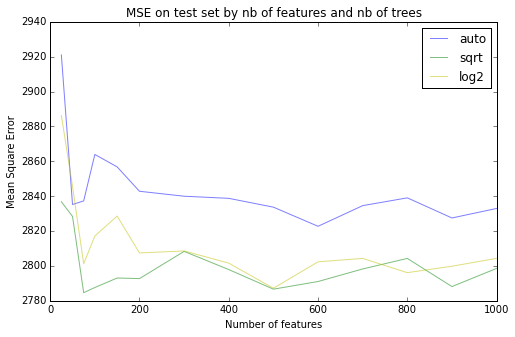

In [137]:
# MSE on test set
fig = plt.gcf()
fig.set_size_inches(8, 5)

for key, co in zip(['auto', 'sqrt', 'log2'], ['b', 'g', 'y']):
    x = randomForest2014[randomForest2014.nb_features == key].nb_trees.values
    y = randomForest2014[randomForest2014.nb_features == key].test_score.values
    plt.plot(x, y, alpha = 0.5, c =co, label = key)

plt.ylabel("Mean Square Error")
plt.xlabel("Number of features")
plt.title("MSE on test set by nb of features and nb of trees")
plt.legend(loc = 1)

plt.show()

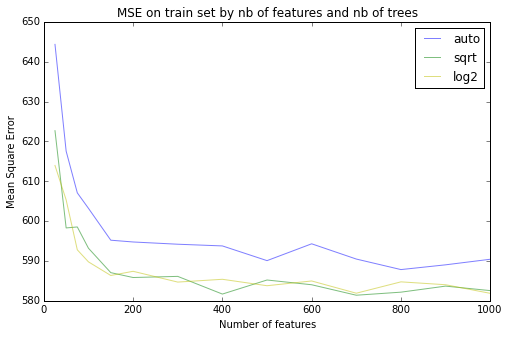

In [139]:
# MSE on train set
fig = plt.gcf()
fig.set_size_inches(8, 5)

for key, co in zip(['auto', 'sqrt', 'log2'], ['b', 'g', 'y']):
    x = randomForest2014[randomForest2014.nb_features == key].nb_trees.values
    y = randomForest2014[randomForest2014.nb_features == key].train_score.values
    plt.plot(x, y, alpha = 0.5, c =co, label = key)

plt.ylabel("Mean Square Error")
plt.xlabel("Number of features")
plt.title("MSE on train set by nb of features and nb of trees")
plt.legend(loc = 1)

plt.show()

# 2. Random forest classifier

We will make prediction on the variable 'ARR_DEL15'. This variable takes the value 1 is the plane is more than 15 minutes late and 0 if not. Let's look at the baseline classifier, that is the classifiers that assign repectively 1 or 0 to 'ARR_DEL15' for every flight.

Here we look at the case whether a flight will be more than 15 minutes late. So we adjust the ARR_DELAY colum to an indicator.

In [22]:
%%time
dexample['ARR_DELAY_COR'] = dexample.ARR_DELAY.map(lambda x: (x >= 15))
dexample.drop('ARR_DELAY', axis = 1, inplace = True)
file_path = "cache/predictionData/dexample_class.csv"
dexample.to_csv(path_or_buf= file_path)
dexample_class = dexample.copy()

Wall time: 1.18 s


In [ ]:
#file_path = "cache/predictionData/dexample_class.csv"
#dexample_class = pd.read_csv(path_or_buf= file_path)
#dexample_class.drop('Unnamed: 0', axis= 1, inplace = True)

In [23]:
dexample_class.head(3)

,DISTANCE_NOR,LAT_NOR,LONG_NOR,CRS_ARR_TIME_COR_NOR,CRS_DEP_TIME_COR_NOR,AIRCRAFT_YEAR_COR_NOR,UNIQUE_CARRIER_AA,UNIQUE_CARRIER_B6,UNIQUE_CARRIER_OO,UNIQUE_CARRIER_UA,...,MONTH_M,MONTH_N,MONTH_O,MONTH_S,DAY_F,DAY_M,DAY_S,DAY_T,DAY_W,ARR_DELAY_COR
2033,0.68881,1.058684,0.786579,0.88939,-1.046771,-1.713677,1,0,0,0,...,0,0,0,0,0,0,0,0,1,False
2034,0.68881,1.058684,0.786579,0.88939,-1.046771,1.129411,1,0,0,0,...,0,0,0,0,0,0,1,0,0,True
2035,0.68881,1.058684,0.786579,0.88939,-1.046771,1.129411,1,0,0,0,...,0,0,0,0,0,0,1,0,0,False


In [24]:
from __future__ import division

def baseline_class(data, target):
    ''' 
    Compute the baseline classifiers along a target variable for a data set data

    Parameters:
    -----------

    data: pandas.DataFrame
       dataframe  

    target: string
        Column of data along wich we compute the baseline classifiers
    '''    
    
    
    score_baseline_1 = np.size(data[data[target] == 1][target].values) / np.size(data[target].values)
    score_baseline_0 = np.size(data[data[target] == 0][target].values) / np.size(data[target].values)
    
    print "baseline classifier everyone to 0: ", int(score_baseline_0*100) , "%"
    print "baseline classifier everyone to 1: ", int(score_baseline_1*100) , "%"
   
    return score_baseline_0, score_baseline_1

In [25]:
baseline_class(dexample_class, 'ARR_DELAY_COR')

baseline classifier everyone to 0:  70 %
baseline classifier everyone to 1:  29 %


(0.7088213306753053, 0.2911786693246947)

## Prediction functions

In [34]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

Random forest functions for a classification task

In [27]:
def split(data, list_drop, target, test_size):
    ''' 
    Splits the data into a training and a test set
    Separates the training and test sets according to a feature set and a target set
    Balance the features sets by retaining only fraction of its points

    Parameters:
    -----------

    data: pandas.DataFrame
       Flight dataframe  

    list_drop: <list 'string'>
        List of columns to exclude from the features set
        
    target: string
        target column along whch we make the target set
        
    test_size: float
        size of the test set
    
    '''    
    
    #split the dataset into a training set and a test set
    dtrain, dtest = train_test_split(data, test_size = 0.3)
    
    Xtrain = dtrain.drop(list_drop, axis=1).values
    ytrain = dtrain[target].values
    Xtest = dtest.drop(list_drop, axis=1).values
    ytest = dtest[target].values
    
    return Xtrain, ytrain, Xtest, ytest

In [35]:
def score_random_forest_classifier(Xtrain, ytrain, Xtest, ytest, n_trees=10, max_features='auto'):
    ''' 
    Fits a random forest with (Xtrain ,ytrain)
    Computes the score on (Xtest, ytest)

    Parameters:
    -----------

    Xtrain: numpy 2D array
       Feature training set

    ytrain: numpy 1D array
        Target training set
    
    Xtest: numpy 2D array
       Feature test set

    ytest: numpy 1D array
        Target test set
    
    n_trees: int
        number of trees in the forest
    
    max_features: string or int
        number of features used for every tree
        
    Outputs:
    --------
    
    score_train: float
        score on the train set
    
    score_test: float
        score on the test set
    
    clf.feature_importances_
        weights of each feature as used by the classifier
    
    ''' 

    clf= RandomForestClassifier(n_estimators=n_trees, max_features= max_features)
    clf.fit(Xtrain, ytrain)
    
    score_train = clf.score(Xtrain, ytrain)
    score_test = clf.score(Xtest, ytest)
    
    return  score_train, score_test, clf

In [36]:
def best_parameters_classifier(Xtrain, ytrain, Xtest, ytest, nb_trees, nb_features):
    ''' 
    Fits sequentially random forest classifiers
    Adds each test score in a pandas.DataFrame with the number of trees, the loss function, the train score,
    and the importance of each features
    Returns a DataFrame with all scores

    Parameters:
    -----------

    Xtrain: numpy 2D array
       Feature training set

    ytrain: numpy 1D array
        Target training set
    
    Xtest: numpy 2D array
       Feature test set

    ytest: numpy 1D array
        Target test set
    
    n_trees: <list int>
        list of numbers of trees in the forest
    
    nb_features: <list int>
        list of number of features in the forest
        
    Outputs:
    --------
    
    score_tab: pandas.DataFrame
        DataFrame of scores with associated parameters
    
    '''
    
    score_tab = pd.DataFrame(columns=['nb_trees', 'nb_features', 'test_score', 'train_score', 'classifier'])
    
    # counter will increment the index in score_tab
    counter = 0 

    for n_estimators in nb_trees:
        for max_features in nb_features:

            score_train, score_test, classifier = \
            score_random_forest_classifier(Xtrain, ytrain, Xtest, ytest, n_trees=n_estimators, max_features=max_features) 
            score_tab.loc[counter] = [n_estimators, max_features, score_test, score_train, classifier]
            counter += 1

    return score_tab

In [37]:
def classify_random_forest_class(data, list_drop, target, test_size=0.4, nb_trees=[10], nb_features = ['auto']):
    Xtrain, ytrain, Xtest, ytest = split(data, list_drop, target, test_size)
    scores =  best_parameters_classifier(Xtrain, ytrain, Xtest, ytest, nb_trees, nb_features)
    return scores

### Classification task

We look at various paramters for the classifier. Note that there are two loss functions available for the random forest classifier, a Gini loss and an entropy loss. Simulations show they behave similarly!

In [99]:
nb_trees = [25, 50, 75, 100, 150, 200, 300, 400, 500, 750, 1000, 2000, 5000]
nb_features = ['sqrt', 'log2']
test_size = 0.4

In [100]:
%%time
randomForest2014_class =  classify_random_forest_class(dexample, ['ARR_DELAY_COR'], 'ARR_DELAY_COR', test_size=test_size, nb_trees=nb_trees, nb_features=nb_features)

Wall time: 28min 59s


In [90]:
randomForest2014_class.head(9)

,nb_trees,nb_features,test_score,train_score,classifier
0,25,sqrt,0.652824,0.934318,"(DecisionTreeClassifier(class_weight=None, cri..."
1,25,log2,0.648671,0.934140,"(DecisionTreeClassifier(class_weight=None, cri..."
2,50,sqrt,0.656561,0.937344,"(DecisionTreeClassifier(class_weight=None, cri..."
3,50,log2,0.657392,0.937344,"(DecisionTreeClassifier(class_weight=None, cri..."
4,75,sqrt,0.660714,0.937878,"(DecisionTreeClassifier(class_weight=None, cri..."
5,75,log2,0.658223,0.937878,"(DecisionTreeClassifier(class_weight=None, cri..."
6,100,sqrt,0.661960,0.937878,"(DecisionTreeClassifier(class_weight=None, cri..."
7,100,log2,0.661545,0.937700,"(DecisionTreeClassifier(class_weight=None, cri..."
8,150,sqrt,0.654900,0.937878,"(DecisionTreeClassifier(class_weight=None, cri..."


In [101]:
# save file to /data/ folder
file_path = "cache/predictionData/randomForest2014_class.csv"
randomForest2014_class.to_csv(path_or_buf= file_path)

### Analysis

Let's now look at the importance coefficients, that the average usage of each coefficients in the random forest. As we can see, the main factors in the delay of a flight are the age of the aircraft, the time of the departure and the time of the origin. The fact that the departure and arrival time confirm what we observed in the explorative analysis. However, the role of the age of the aircraft was not very marked in the explorative analysis. Lastly, the weekday has a huge influence.

Notice that the airline and the aircraft model play a very limited role in the delay according to this random forest classifier.

In [106]:
features = dexample_class.drop('ARR_DELAY_COR', axis =1).columns
coeffs_class = randomForest2014_class.classifier[len(randomForest2014_class)-1].feature_importances_
u = pd.Series(coeffs_class, index=features)
u.sort(inplace=True, ascending=False)
print u

AIRCRAFT_YEAR_COR_NOR                          0.285870
CRS_ARR_TIME_COR_NOR                           0.217206
CRS_DEP_TIME_COR_NOR                           0.212159
DAY_T                                          0.027670
DAY_S                                          0.026794
DAY_W                                          0.022723
DAY_F                                          0.021133
DAY_M                                          0.020281
MONTH_J                                        0.017575
MONTH_A                                        0.015214
MONTH_M                                        0.013477
MONTH_O                                        0.013426
AIRCRAFT_MFR_AIRBUS INDUSTRIE                  0.013183
AIRCRAFT_MFR_BOEING                            0.012232
MONTH_S                                        0.012192
MONTH_F                                        0.011634
MONTH_N                                        0.010826
MONTH_D                                        0

### Score by size of the forest

In [93]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

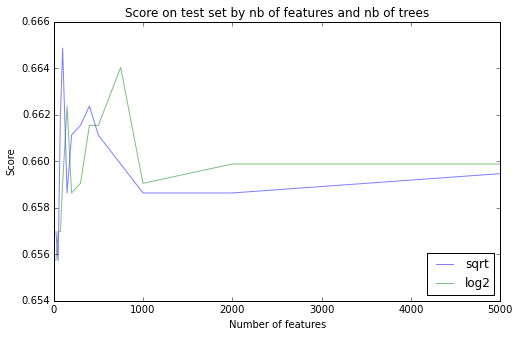

In [107]:
# Score on test set
fig = plt.gcf()
fig.set_size_inches(8, 5)

for key, co in zip(['sqrt', 'log2'], ['b', 'g']):
    x = randomForest2014_class[randomForest2014_class.nb_features == key].nb_trees.values
    y = randomForest2014_class[randomForest2014_class.nb_features == key].test_score.values
    plt.plot(x, y, alpha = 0.5, c =co, label = key)

plt.ylabel("Score")
plt.xlabel("Number of features")
plt.title("Score on test set by nb of features and nb of trees")
plt.legend(loc = 4)

plt.show()

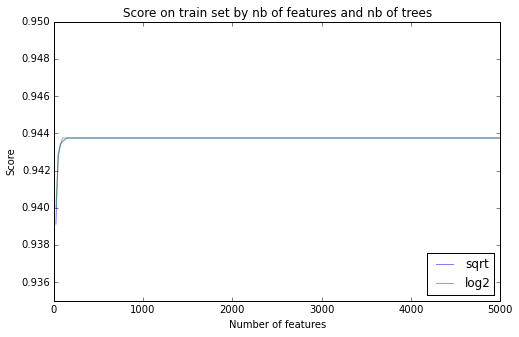

In [111]:
# Score on train set
fig = plt.gcf()
fig.set_size_inches(8, 5)

for key, co in zip(['sqrt', 'log2'], ['b', 'g']):
    x = randomForest2014_class[randomForest2014_class.nb_features == key].nb_trees.values
    y = randomForest2014_class[randomForest2014_class.nb_features == key].train_score.values
    plt.plot(x, y, alpha = 0.5, c =co, label = key)

plt.ylim(0.935, 0.95)
plt.ylabel("Score")
plt.xlabel("Number of features")
plt.title("Score on train set by nb of features and nb of trees")
plt.legend(loc = 4)

plt.show()